# Modularize PyTorch Model Training

This notebook transforms [Getting Started With Custom Datasets](Getting%20Started%20With%20Custom%20Datasets.ipynb) notebook code to Python modules. We will modularize the following sections:

- [Data Preparation](#data-preparation).
  - [Procurement](#procurement)
- [Dataset Creation](#create-datasets-and-dataloaders-data_setuppy)
- [TinyVGG Model](#tinyvgg-module_builderpy)
- [Training Functions](#training-functions-enginepy)
- [Saving and Loading Models](#saving-and-loading-models-and-other-utility-functions-utilspy)
- [Training and Evaluation](#train-evaluate-and-save-the-model-trainpy)

We'll follow the [PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular) tutorial by [@mrdbourke](https://github.com/mrdbourke/pytorch-deep-learning)

# Import Modules

In [17]:
import random

from pathlib import Path
from PIL import Image

# Setup Module Directory

In [39]:
%%writefile 'modularization_example/notebook_utils.py'

from IPython import display

def display_color(message, color = None):
    def color_fn():
        return display.HTML(f'<font style="color: {color}">{message}</font>')
    
    display(color_fn() if color else message)

Writing modularization_example/notebook_utils.py


In [40]:
from modularization_example import notebook_utils

project_path = Path('./modularization_example')

if project_path.exists():
    display_color(f'Using Project Directory: {project_path}', 'green')
else:
    display_color(f'Creating Project Directory: {project_path}', 'green')
    project_path.mkdir(parents=True, exist_ok=True)
    notebook_utils.display_color(f'Using Project Directory: {project_path}')

# Data Preparation

## Procurement

We will download the [Food101](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip) dataset.

In [20]:
import os
import requests
import zipfile

# 1. Setup path to data folder
data_path = Path(os.path.expanduser("~/.datasets/"))
image_path = data_path / "pizza_steak_sushi"
train_path = image_path / 'train'
test_path = image_path / 'test'

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # 2. Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # 3. Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

/Users/broxoli/.datasets/pizza_steak_sushi directory exists.


### Exploration

In [21]:
def summarize_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        if len(dirnames) != 0:
            print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
        else:
            print(f"There are {len(filenames)} images in '{dirpath}'.")

print('Training Set')
print('------------')
summarize_dir(train_path)

print('\nTest Set')
print('------------')
summarize_dir(test_path)

Training Set
------------
There are 3 directories and 0 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train'.
There are 75 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train/steak'.
There are 72 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train/sushi'.
There are 78 images in '/Users/broxoli/.datasets/pizza_steak_sushi/train/pizza'.

Test Set
------------
There are 3 directories and 0 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test'.
There are 19 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test/steak'.
There are 31 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test/sushi'.
There are 25 images in '/Users/broxoli/.datasets/pizza_steak_sushi/test/pizza'.


### Visualization

Path: /Users/broxoli/.datasets/pizza_steak_sushi/train/steak/2614189.jpg
Class: steak
Size: 512 x 512


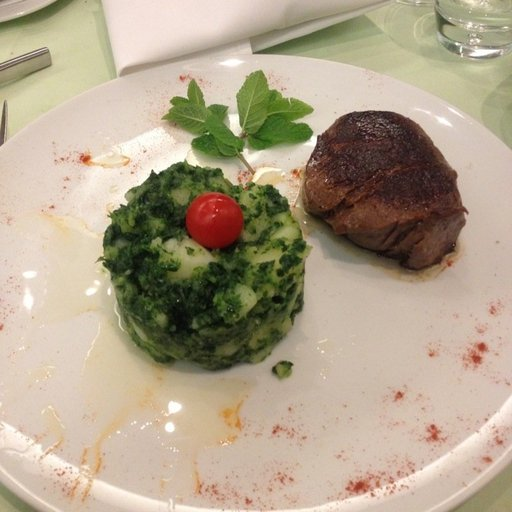

In [22]:
SEED = 3
random.seed(SEED)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open the random image
image = Image.open(random_image_path)

# 5. Print metadata
print(f"Path: {random_image_path}")
print(f"Class: {image_class}")
print(f"Size: {image.height} x {image.width}") 

display(image)

# Create Datasets and DataLoaders ([data_setup.py](./modularization_example/data_setup.py))

We apply the following transformations:
- Resize input image to 64x64.
- Convert input to tensors.

In [23]:
%%writefile {project_path / 'data_setup.py'}

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

WORKERS = os.cpu_count()

def create_dataloaders(
    train_path: Path,
    test_path: Path,
    transform: transforms.Compose,
    batch_size: int,
    workers: int = WORKERS
):
    """Creates train and test DataLoaders

    Creates DataLoaders to load data from train_path and test_path.

    Arguments:
        train_path: Path to training data directory.
        test_path: Path to testing data directory.
        transform: torchvision transform to apply over the training and testing data.
        batch_size: The number of samples in each batch of DataLoaders.
        workers: The number of workers per DataLoader to read the data.
    """
    # 1.  Create Datasets using datasets.ImageFolder
    train_data = datasets.ImageFolder(root=train_path, transform=transform)
    test_data = datasets.ImageFolder(root=test_path, transform=transform)

    # 2. Get the classes in the input data.
    class_names = train_data.classes
    class_dict = train_data.class_to_idx

    # 3. Print basic data information
    print('Training Set')
    print('------------')
    print(f'{train_data}')
    print(f'Classes: {train_data.classes}')
    print(f'Class Dictionary: {train_data.class_to_idx}')

    print('\nTest Set')
    print('------------')
    print(f'{test_data}')
    print(f'Classes: {test_data.classes}')
    print(f'Class Dictionary: {test_data.class_to_idx}')

    # 4. Batch the data using DataLoaders.
    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        num_workers=workers,
        shuffle=True,
        pin_memory=True,
    )

    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        num_workers=workers,
        shuffle=True,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

Overwriting modularization_example/data_setup.py


# TinyVGG ([module_builder.py](./modularization_example/module_builder.py))

In [24]:
%%writefile {project_path / 'module_builder.py'}

import torch

import torch.nn as nn

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

Overwriting modularization_example/module_builder.py


# Training Functions ([engine.py](./modularization_example/engine.py))

In [25]:
%%writefile {project_path / 'engine.py'}

"""
Contains training functions.
"""

import torch

import torch.nn as nn

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Callable

def train_step(model, dataloader, loss_fn, optimizer, accuracy_fn, device):
    ### Setup initial training state
    training_loss, training_accuracy = 0., 0.
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Send data to the appropriate device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_logits = model(X)
        y_pred = y_logits.softmax(1).argmax(1)

        # 2. Compute Loss and Accuracy
        loss = loss_fn(y_logits, y)
        accuracy = accuracy_fn(y, y_pred)

        training_loss += loss.item()
        training_accuracy += accuracy

        # 3. Clear Optimizer Gradients
        optimizer.zero_grad()

        # 4. Backward Pass
        loss.backward()

        # 5. Update Weights
        optimizer.step()
    
    ### Aggregate losses and accuracies
    training_loss /= len(dataloader)
    training_accuracy /= len(dataloader)

    return training_loss, training_accuracy

def test_step(model, dataloader, loss_fn, accuracy_fn, device):
    ### Setup epoch evaluation state
    test_loss, test_accuracy = 0., 0.
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the appropriate device
            X, y = X.to(device), y.to(device)

            # 1. Forward Pass
            y_logits = model(X)
            y_pred = y_logits.softmax(1).argmax(1)

            # 2. Compute Loss and Accuracy
            loss = loss_fn(y_logits, y)
            accuracy = accuracy_fn(y, y_pred)

            test_loss += loss.item()
            test_accuracy += accuracy
    
        ### Aggregate losses and accuracies for the test set.
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)
    
    return test_loss, test_accuracy

def train(
    model: torch.nn.Module, 
    train_dataloader: DataLoader, 
    test_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer,
    accuracy_fn: Callable,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    device: str = 'cpu',
    epochs: int = 5
):
    
    # 1. Create a container for the results
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 2. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )
        
        # 3. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 5. Return the filled results at the end of the epochs
    return results

Overwriting modularization_example/engine.py


# Saving and loading models, and other utility functions ([utils.py](./modularization_example/utils.py))

In [26]:
%%writefile {project_path / 'utils.py'}

"""
Utility functions to save and load PyTorch models.
"""
import torch
import pathlib

def get_device():
    device = 'cpu'

    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    
    return device

def accuracy_fn(y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_pred)

def save_model(
    model: torch.nn.Module,
    target_dir_path: pathlib.PosixPath,
    filename: str
):
    """Saves a PyTorch model to a target directory.

    Args:
        model: PyTorch Model to save.
        target_dir_path: Target directory for the saved model.
        filename: A filename for the saved model. It should include
            ".pth" or ".pt" file extensions.

    Example usage:
        save_model(
            model=model,
            target_dir_path="models",
            filename="model.pth"
        )
    """
    # 1. Create the target directory
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert filename.endswith(".pth") or filename.endswith(".pt"), "filename should end with '.pt' or '.pth'"
    model_path = target_dir_path / filename

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_path}")
    torch.save(obj=model.state_dict(), f=model_path)

Overwriting modularization_example/utils.py


# Train, evaluate and save the model ([train.py](./modularization_example/train.py))

In [27]:
%%writefile {project_path / 'train.py'}

import os
import torch
import data_setup, engine, module_builder, utils

import torch.nn as nn

from pathlib import Path
from torchvision import transforms
from timeit import default_timer as timer

# 1. Setup hyperparameters
BATCH_SIZE, EPOCHS, LEARNING_RATE = 32, 5, 0.001
HIDDEN_UNITS = 10
IMG_SIZE = 64

def main():
    # 2. Setup path to data folder
    data_path = Path(os.path.expanduser("~/.datasets/pizza_steak_sushi"))
    train_path = data_path / 'train'
    test_path = data_path / 'test'

    # 3. Setup target device
    device = utils.get_device()

    # 4. Create data transforms
    data_transform = transforms.Compose([
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    # 5. Create dataloaders
    train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
        train_path=train_path,
        test_path=test_path,
        transform=data_transform,
        batch_size=BATCH_SIZE
    )

    # 6. Setup a random seed
    torch.manual_seed(SEED)
    torch.mps.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    # 7. Create a model
    model = module_builder.TinyVGG(
        input_shape=3,
        hidden_units=HIDDEN_UNITS,
        output_shape=len(class_names)
    ).to(device)

    print('Model Architecture')
    print('------------------')
    print(f'{model} on {device}')

    print('\nModel Parameters')
    print(f'-------------------')
    for name in model.state_dict().keys():
        print(f'{name}')

    # for (name, param) in model_0.state_dict().items():
    #     print(f'{name}: {param}')

    xt = torch.randn(2, 3, IMG_SIZE, IMG_SIZE, device=device)
    yt = model(xt)

    print('\nInputs and Outputs')
    print('-------------------')
    print(f'Input: {xt}')
    print(f'Output: {yt}')
    print(f'Input Shape: {xt.shape} Output Shape: {yt.shape}')

    # 8. Setup loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lr=LEARNING_RATE, params=model.parameters())

    # 9. Train the model
    print('Training Loop')
    print('-------------')
    print('-------------')

    start_time = timer()

    model_results = engine.train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        accuracy_fn=utils.accuracy_fn,
        epochs=EPOCHS,
        device=device
    )

    end_time = timer()

    print(f"Total training time: {end_time - start_time:.3f} seconds")

    # 10. Save the model
    utils.save_model(
        model=model,
        target_dir_path=Path('models'),
        filename='food_classification.pth'
    )

if __name__ == '__main__':
    main()

Overwriting modularization_example/train.py


In [ ]:
! python modularization_example/train.py